# Learning Virtual Values

In this tutorial, we will extend the ideas from the [previous tutorial](learning-position-auctions.ipynb).  We will consider position auctions, like those found in paid search marketplaces, but focus on virtual value transformations rather than payment and allocation networks.

## Motivating example

Consider a two-bidder, two-slot position auction where the values for the two bidders are correlated.  There is a signal $c\sim U[0,1]$, which we intepret as a _conversion rate_.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2.

The first slot has a click-through-rate (quality) of 1.  The second slot has a click-through-rate of 0.5.  A bidder may purchase one slot only, so we can consider this a special case of a multi-item, unit-demand scenario.

## Architectures and supporting functions

In this tutorial, we will make use of Monotonic networks.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

We add common `dmch` components:

In [3]:
import dmch
from dmch import Mechanism
from dmch import SequentialMechanism
from dmch import build_spa, create_spa_mechanism


Now we define the auction scenario:

In [4]:
# Number of bidders
bidders = 2

# Pr(click|position)
slot_weights = [1, 0.5]

# Number of slots
slots = len(slot_weights)


## GSP

For comparison, we define the GSP mechanism by using sequantial second-price auctions (SPA):

In [5]:
def create_gsp_mechanism():
    mbuilder = dmch.build_spa(bidders, context_features=1)
    return mbuilder.build_sequential(slots,weights=slot_weights)

## MyersonNet

The allocation network is defined as follows:

In [6]:
def create_myerson_net(context_features=0, hidden_features=100, linear_functions=1, groups=1):
    mbuilder = dmch.build_spa(bidders, context_features=context_features)
    
    mbuilder.set_virtual_function(
        hidden_features=hidden_features,
        linear_functions=linear_functions,
        groups=groups)
    
    return mbuilder.build_sequential(slots,weights=slot_weights)

## Auction for the motivating example



The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [7]:
import torch.utils.data as data_utils

epochs = 500
sample_size = 2**15
batch_size = 2**12

indepedent_components = torch.rand(sample_size, bidders)
common_components = torch.rand(sample_size, 1)
inputs = indepedent_components * common_components
inputs_with_common = torch.cat([indepedent_components * common_components, common_components], dim=1)

inputs_loader=data_utils.DataLoader(
    data_utils.TensorDataset(inputs),
    batch_size=batch_size)

inputs_with_common_loader=data_utils.DataLoader(
    data_utils.TensorDataset(inputs_with_common),
    batch_size=batch_size)

Before training the networks, let's establish a GSP baseline.

In [8]:
gsp = create_gsp_mechanism()
gsp_report = pd.DataFrame(
    dmch.evaluate(
        gsp,
        inputs_loader,
        bidders,
        epochs=epochs,
        device=device,
        misreport_lr=1e-1,
        misreport_epochs=100))

We now create a simple MyersonNet instance.

In [9]:
myerson_net = create_myerson_net().to(device)

We loop over the data for a number of epochs and record traces of the networks learning.

In [10]:
myerson_net_report = pd.DataFrame(dmch.train(
    myerson_net, # the mechanism
    inputs_loader, # the bid inputs
    bidders, # the number of bidders
    epochs=epochs, # the total number of loops over the data
    device=device, # the device
    rho=1e2, # the rho parameter for the augmented Lagrangian method
    mechanism_lr=1e-3, # the learning rate for the mechanism networks
    consider_dsic=False,
    consider_ir=False))

100%|██████████| 500/500 [01:59<00:00,  3.94it/s]


We can also test supplying MyersonNet with the common signal:

In [11]:
myerson_net_with_common = create_myerson_net(context_features=1).to(device)

myerson_net_with_common_report = pd.DataFrame(dmch.train(
    myerson_net_with_common, # the mechanism
    inputs_with_common_loader, # the bid inputs
    bidders, # the number of bidders
    epochs=epochs, # the total number of loops over the data
    device=device, # the device
    rho=1e2, # the rho parameter for the augmented Lagrangian method
    mechanism_lr=1e-3, # the learning rate for the mechanism networks
    consider_dsic=False,
    consider_ir=False))

100%|██████████| 500/500 [02:25<00:00,  3.41it/s]


Let's review the revenue of the network: _MyersonNet_ exceeds _GSP_ revenue and _MyersonNet with common_.  Adding the common signal as context allows MyersonNet to condition on that context, which reduces a problem of finding an optimal reserve for two IID bidders from U[0,common].

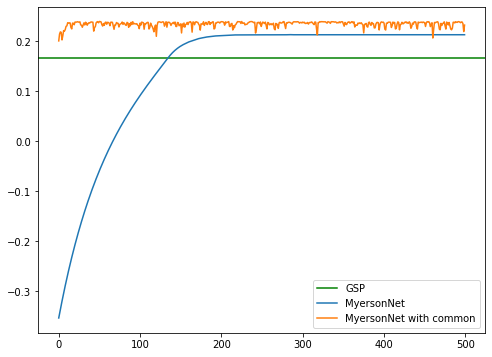

In [12]:
fig, ax = plt.subplots(figsize=(8,6));
ax.axhline(y=gsp_report.mean()[['revenue']].values, color='g', label='GSP');
ax.plot(myerson_net_report.groupby('epoch')[['revenue']].mean(), label='MyersonNet');
ax.plot(myerson_net_with_common_report.groupby('epoch')[['revenue']].mean(), label='MyersonNet with common');
ax.legend();

In [13]:
def plot_mechanism(mechanism, common=1):
    X, Y = np.meshgrid(
        np.arange(0.0, common, 0.01),
        np.arange(0.0, common, 0.01))
    
    n = X.shape[0]*X.shape[1]
    
    inputs = torch.cat(
        (torch.from_numpy(np.reshape(X, (n,1))),
         torch.from_numpy(np.reshape(Y, (n,1)))),
        dim=1).float().to(device)
    
    inputs = torch.cat((inputs,torch.zeros(n,1).float().to(device)),dim=1)
    inputs[:,2] = common
    
    allocation, payment = mechanism(inputs)
    
    allocation_levels = np.arange(0, 1.5, 0.01)
    bid_levels = np.arange(0, 1.0, 0.01)
    fig, axes = plt.subplots(nrows=2, ncols=bidders+1, figsize=(20,10));
    
    def plot_contour(tensor,axis_index,bidder_title,main_title,levels):
        for bidder in range(bidders):
            CS = axes[axis_index,bidder].tricontourf(
                inputs[:,0].cpu().numpy(),
                inputs[:,1].cpu().numpy(),
                tensor[:,bidder].detach().cpu().numpy(),
                levels=levels,
                cmap="RdBu_r",
                extend='both');
            fig.colorbar(CS, ax=axes[axis_index,bidder]);
            axes[axis_index,bidder].set_title(bidder_title+str(bidder));
        CS = axes[axis_index,bidders].tricontourf(
            inputs[:,0].cpu().numpy(),
            inputs[:,1].cpu().numpy(),
            tensor.sum(dim=1).detach().cpu().numpy(),
            levels=levels,
            cmap="RdBu_r",
            extend='both');
        fig.colorbar(CS, ax=axes[axis_index,bidders]);
        axes[axis_index,bidders].set_title(main_title);
    plot_contour(allocation,0,'Allocation to bidder ','Allocation to all bidders',allocation_levels)
    plot_contour(payment,1,'Payment from bidder ','Payment from all bidders',allocation_levels)

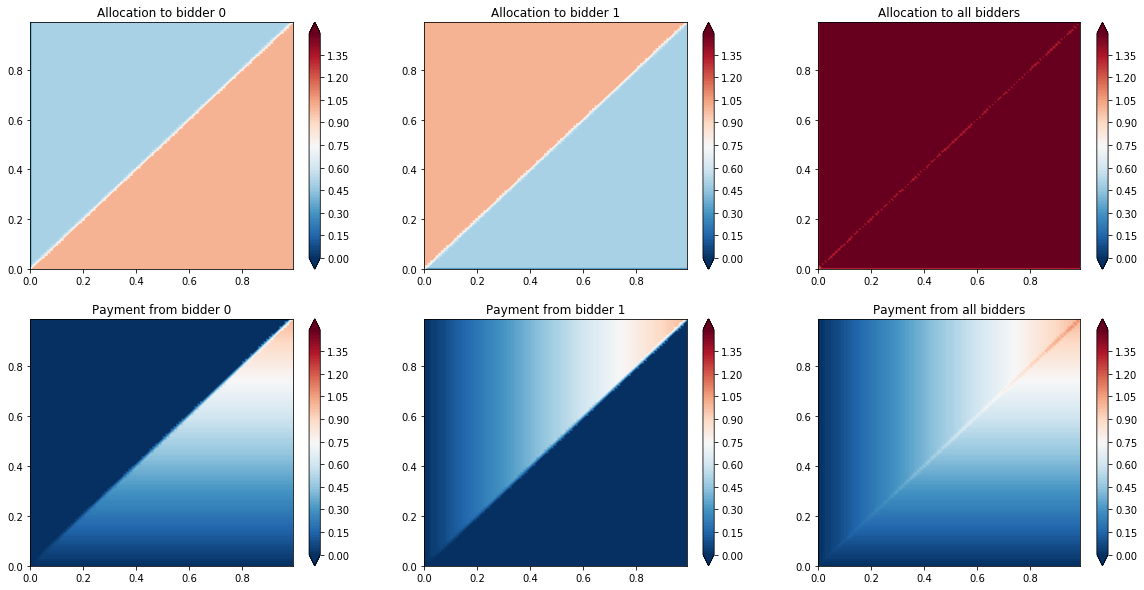

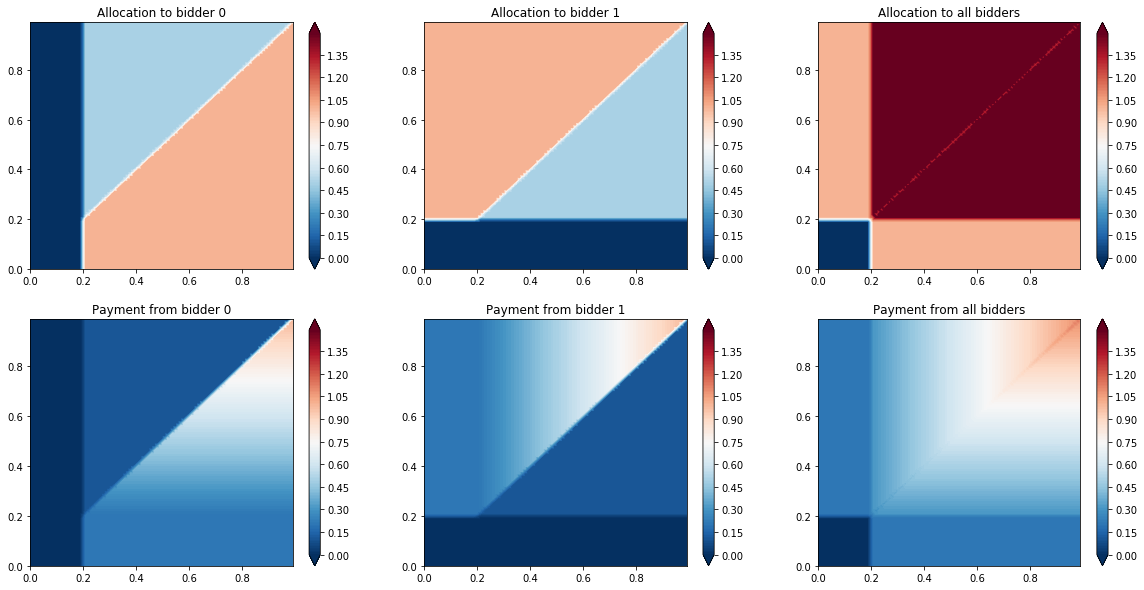

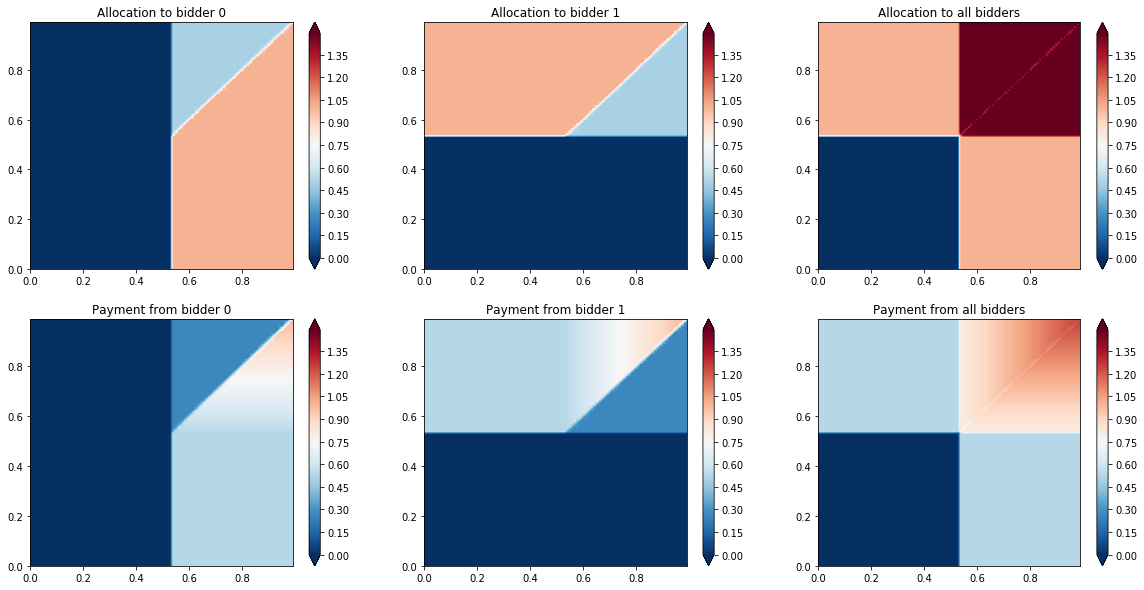

In [14]:
plot_mechanism(gsp,common=1)
plot_mechanism(myerson_net,common=1)
plot_mechanism(myerson_net_with_common,common=1)

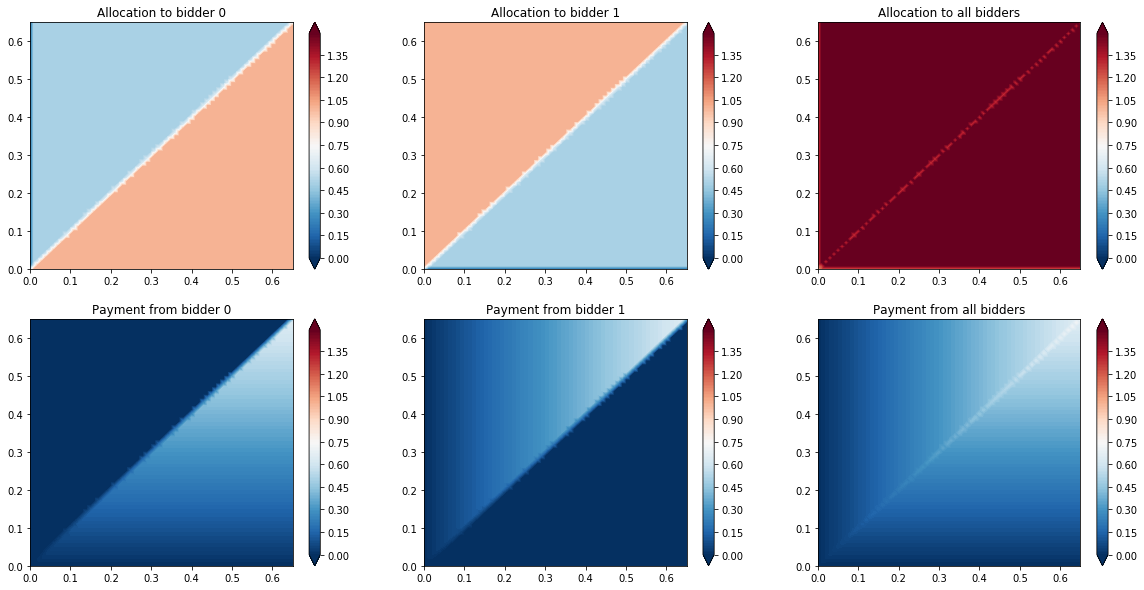

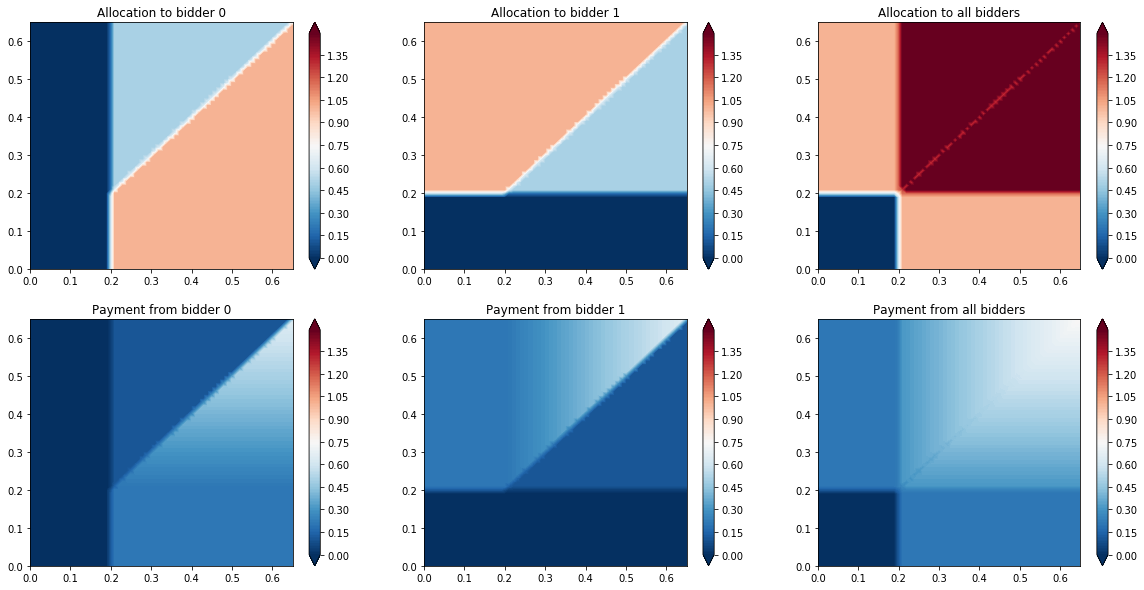

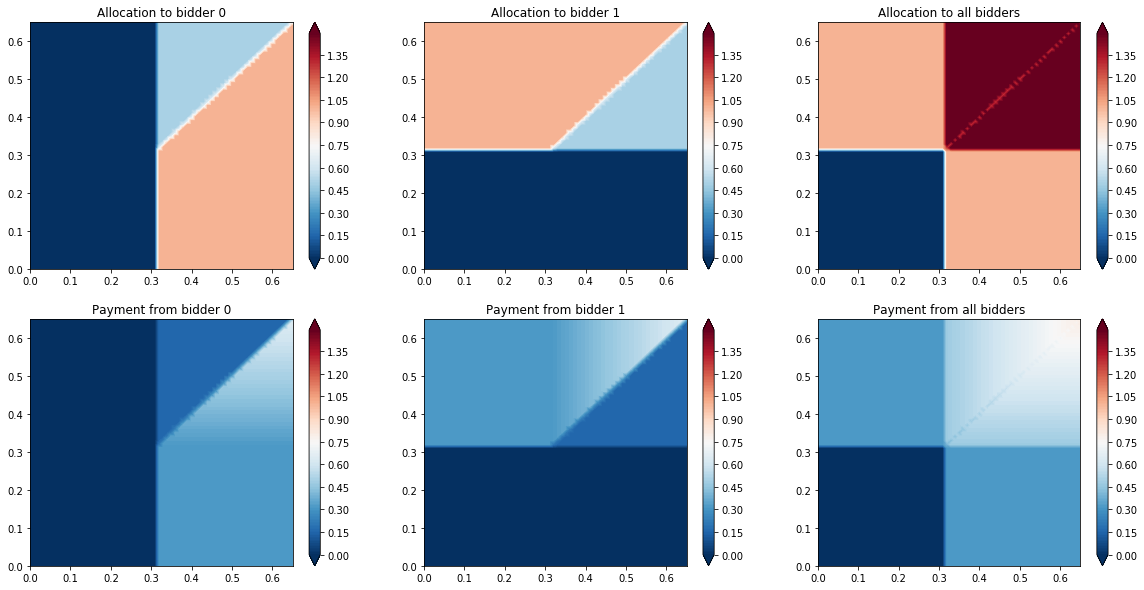

In [15]:
plot_mechanism(gsp,common=0.66)
plot_mechanism(myerson_net,common=0.66)
plot_mechanism(myerson_net_with_common,common=0.66)

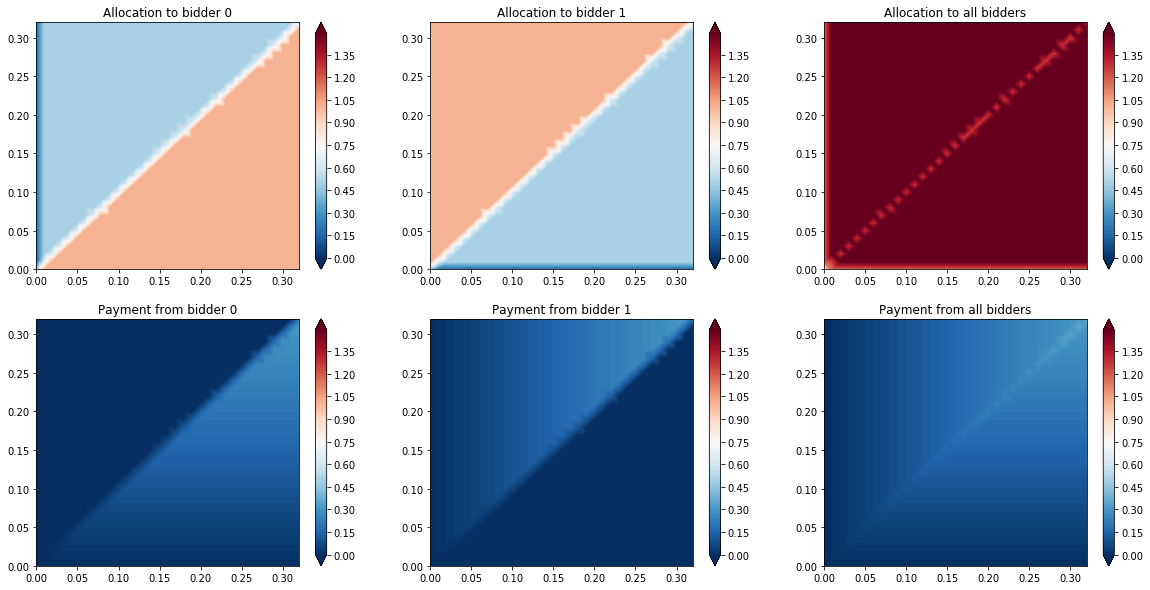

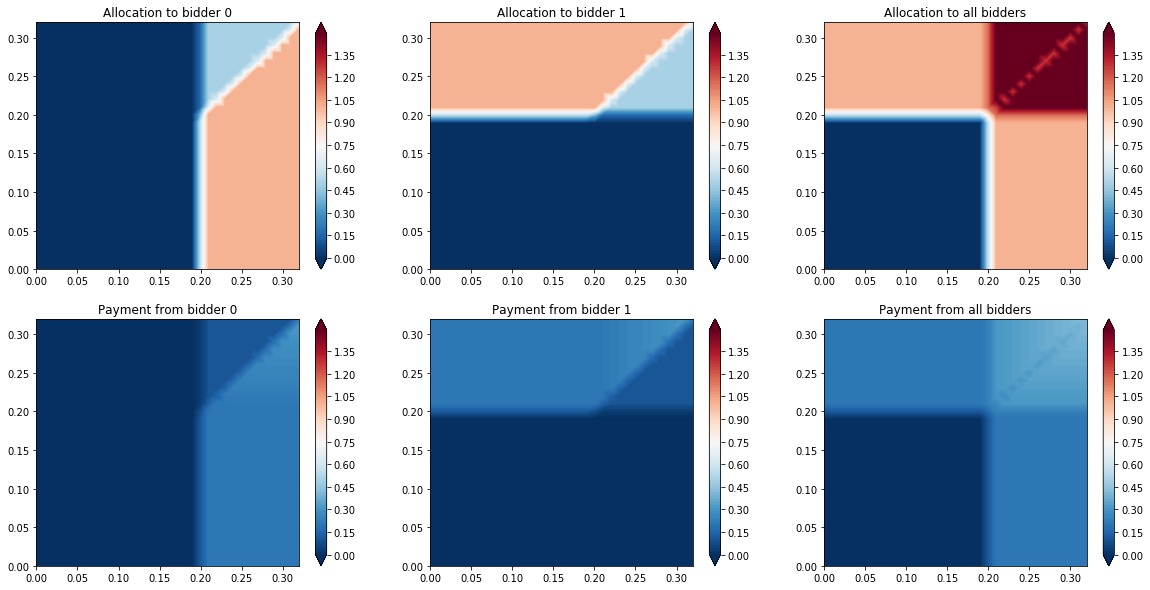

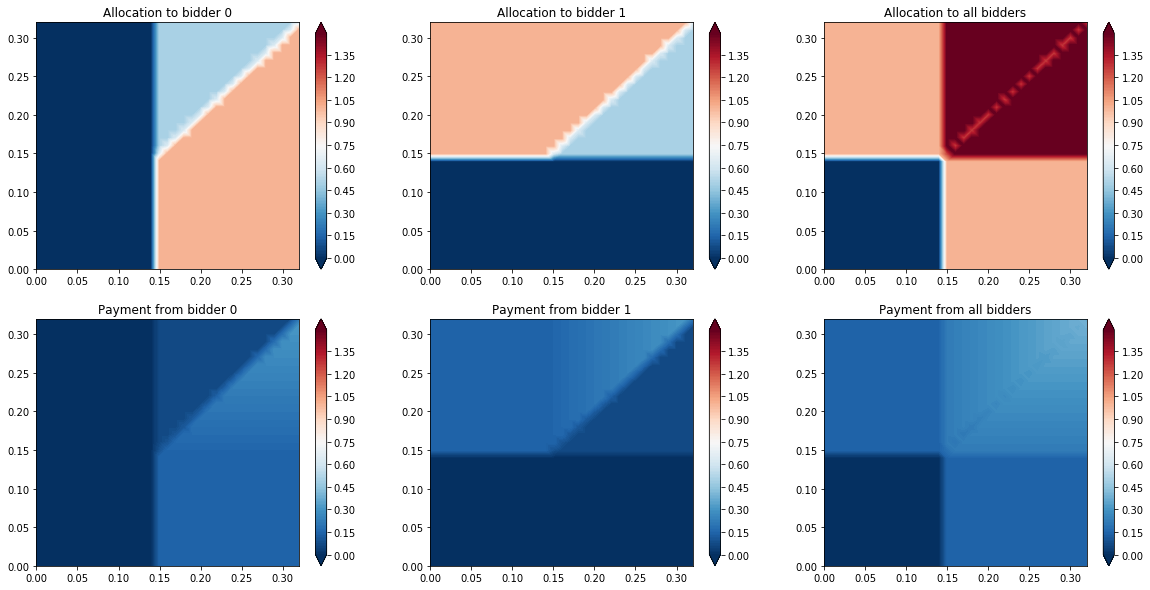

In [16]:
plot_mechanism(gsp,common=0.33)
plot_mechanism(myerson_net,common=0.33)
plot_mechanism(myerson_net_with_common,common=0.33)